In [171]:
import torch
x = torch.ones(1, 2)
z_q = torch.ones(1, 2)

In [172]:
x[:, 0] = 1
x[:, 1] = 1

z_q[:, 0] = 1
z_q[:, 1] = 0.5

In [173]:
x,z_q

(tensor([[1., 1.]]), tensor([[1.0000, 0.5000]]))

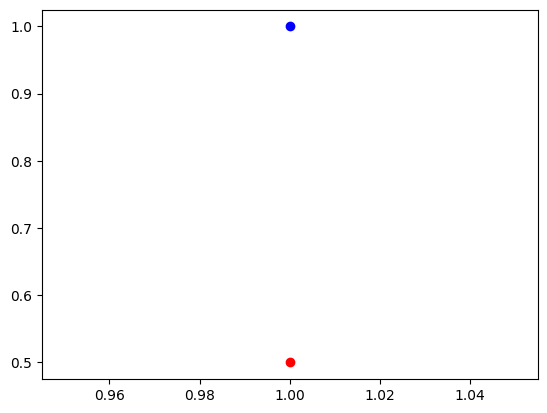

In [174]:
import matplotlib.pyplot as plt

plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), label='x', color='blue')
plt.scatter(z_q[:, 0].numpy(), z_q[:, 1].numpy(), label='z_q', color='red')

In [175]:
def get_very_efficient_rotation(u, q, e):
    w = ((u + q) / torch.norm(u + q, dim=1, keepdim=True)).detach()
    e = e - 2 * torch.bmm(torch.bmm(e, w.unsqueeze(-1)), w.unsqueeze(1)) \
        + 2 * torch.bmm(torch.bmm(e, u.unsqueeze(-1).detach()), q.unsqueeze(1).detach())
    return e

In [176]:
get_very_efficient_rotation(x / (torch.norm(x, dim=1, keepdim=True) + 1e-6),
                            z_q / (torch.norm(z_q, dim=1, keepdim=True) + 1e-6),
                            x.unsqueeze(1)).squeeze()

tensor([1.2649, 0.6325])

In [177]:
import torch.nn.functional as F 
x = F.normalize(x, dim=1)
z_q = F.normalize(z_q, dim=1)

get_very_efficient_rotation(x / (torch.norm(x, dim=1, keepdim=True) + 1e-6),
                            z_q / (torch.norm(z_q, dim=1, keepdim=True) + 1e-6),
                            x.unsqueeze(1)).squeeze()

tensor([0.8944, 0.4472])

In [178]:
z_q

tensor([[0.8944, 0.4472]])

In [232]:
def get_very_efficient_rotation(u, q, e):
    w = ((u + q) / torch.norm(u + q, dim=1, keepdim=True)).detach()
    e = e - 2 * torch.bmm(torch.bmm(e, w.unsqueeze(-1)), w.unsqueeze(1)) + 2 * torch.bmm(
      torch.bmm(e, u.unsqueeze(-1).detach()), q.unsqueeze(1).detach())
    return e

b, c, h, w = 1,2,1,1
x = torch.ones(b, c, h, w)
quantized = torch.eye(2,2)[:1,:].unsqueeze(-1).unsqueeze(-1)
x = x.contiguous().view(-1,c)
quantized = quantized.contiguous().view(-1,c)

print(x, quantized)

x = x / (torch.norm(x, dim=1, keepdim=True))
quantized = quantized / (torch.norm(quantized, dim=1, keepdim=True))
print(f"Angle between x and quantized: {torch.rad2deg(torch.acos(torch.sum(x * quantized, dim=1)))}")
      
pre_norm_q = get_very_efficient_rotation(x / (torch.norm(x, dim=1, keepdim=True) ),
                                            quantized / (torch.norm(quantized, dim=1, keepdim=True)),
                                            x.unsqueeze(1)).squeeze()

tensor([[1., 1.]]) tensor([[1., 0.]])
Angle between x and quantized: tensor([45.])


In [ ]:
print( pre_norm_q, quantized) # tensor([ 1.0000e+00, -5.9605e-08]) tensor([[1., 0.]])

tensor([ 1.0000e+00, -5.9605e-08]) tensor([[1., 0.]])


In [231]:
x, quantized

(tensor([[0.7071, 0.7071]]), tensor([[1., 0.]]))